In [1]:
!pip install numba==0.58.1
!pip install clifford
!pip install "numpy<2.0" numba==0.58.1

import clifford as cf

layout, blades = cf.Cl(3)

e1 = blades['e1']
e2 = blades['e2']
e3 = blades['e3']
e12 = blades['e12']
e13 = blades['e13']
e23 = blades['e23']
e123 = blades['e123']

  Using cached clifford-1.4.0-py3-none-any.whl.metadata (5.1 kB)
Using cached clifford-1.4.0-py3-none-any.whl (159 kB)


--- Magnetic Field Bivector at Origin at t_peak ---
Coil 1 B: 0.021
Coil 2 B: 0.021
Coil 3 B: 0.021
Coil 4 B: 0.021
---------------------------------
Total B: 0.0000
Calculating B-field magnitude over one period...
  - Processing point: Origin
  - Processing point: On Z-axis (z=2cm)
  - Processing point: Off-axis (x=1cm, y=1cm)


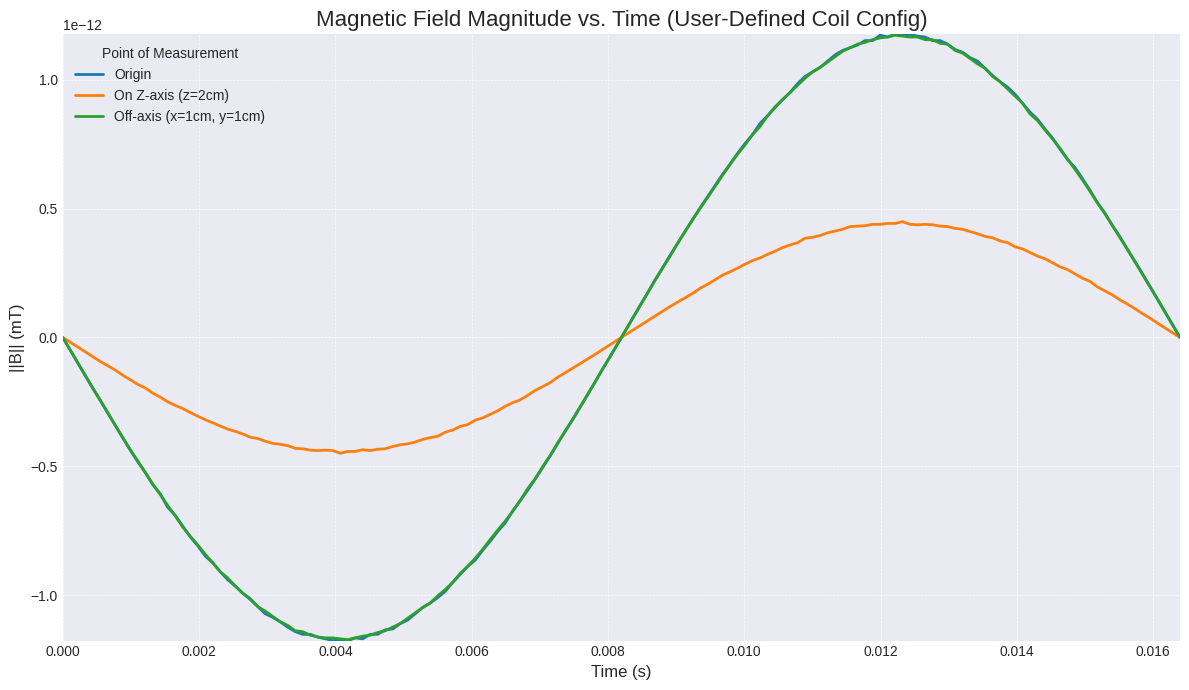

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from math import tau
from clifford import MultiVector

# --- Physical Constants ---
# Using more descriptive names
MU_0 = 2.0e-7 * tau  # Vacuum permeability (μ₀ = 4π × 10⁻⁷ H/m)


class Coil:
    """
    Represents a circular coil of wire and calculates its magnetic field.

    The calculations are performed using Geometric Algebra, where the magnetic
    field B is represented as a bivector. The coil can be arbitrarily positioned
    and oriented in space.
    """

    def __init__(self, radius, turns, current_amplitude, frequency,
                 rotation_angle=0.0, rotation_axis=e23):
        """
        Initializes the Coil object.

        Args:
            radius (float): The radius of the coil in meters.
            turns (int): The number of turns in the coil.
            current_amplitude (float): The peak current (I_max) in Amperes.
            frequency (float): The angular frequency (ω) of the AC current in rad/s.
            center (layout.MultiVector): The position vector of the coil's center. Defaults to the origin.
            rotation_angle (float): The angle to rotate the coil in radians.
            rotation_axis (layout.MultiVector): The bivector representing the plane of rotation.
        """
        self.radius = radius
        self.turns = turns
        self.I_max = current_amplitude
        self.omega = frequency

        # Create the rotor for the coil's orientation
        # A rotor R is defined as R = exp(-θ/2 * B), where B is the rotation plane (bivector)
        self.rotor = np.e**(- (rotation_angle / 2.0) * rotation_axis)
        self.inv_rotor = ~self.rotor  # The inverse of a rotor is its reverse

    def _current(self, t):
        """Calculates the instantaneous current I(t) at time t."""
        return self.I_max * np.sin(self.omega * t)

    def _position_vector(self, angle):
        """
        Calculates the position vector (r') of an element on the un-rotated coil.
        The base coil lies in the x-y plane, centered at the origin.
        """
        return (self.radius * np.cos(angle)) * e1 + (self.radius * np.sin(angle)) * e2 - (self.radius / 2.0) * e3

    def _differential_vector(self, angle):
        """
        Calculates the differential line element (dl') for an un-rotated coil element.
        This is the derivative of the position vector w.r.t. the angle.
        """
        return (-self.radius * np.sin(angle)) * e1 + (self.radius * np.cos(angle)) * e2

    def B_differential(self, point, t, angle):
        """
        Calculates the differential magnetic field bivector (dB) from a coil element.

        This implements the Biot-Savart Law in Geometric Algebra form:
        dB = (μ₀ * N * I / 4π) * (dl' ∧ (r - r')) / |r - r'|³

        Args:
            point (layout.MultiVector): The point in space (r) to calculate the field at.
            t (float): The time at which to calculate the field.
            angle (float): The angle parameterizing the position on the coil.

        Returns:
            layout.MultiVector: The differential magnetic field bivector dB.
        """
        # Apply rotation to the local coil element's position and differential vector
        r_prime_global = self.rotor * self._position_vector(angle) * self.inv_rotor
        dl_prime = self.rotor * self._differential_vector(angle) * self.inv_rotor


        # Biot-Savart Law components
        distance_vec = point - r_prime_global
        dist_mag_cubed = abs(distance_vec)**3

        # Avoid division by zero if the point is on the wire
        if dist_mag_cubed < 1e-12:
            return MultiVector(value=0)

        numerator = dl_prime ^ distance_vec

        # The constant part of the law
        constant = (MU_0 * self.turns * self._current(t)) / (2.0 * tau)

        return constant * numerator / dist_mag_cubed

    def B(self, point, t) -> MultiVector:
        """
        Calculates the total magnetic field bivector B at a point and time.
        This numerically integrates the B_differential function over the entire coil.
        """
        func_to_integrate = lambda angle: self.B_differential(point, t, angle).value
        integral_result, _ = quad_vec(func_to_integrate, 0, tau)
        return layout.MultiVector(value=integral_result)


if __name__ == '__main__':
    # --- Simulation Parameters ---
    R = 6.7e-2
    I_AMP = 10.0
    FREQ = 61.0 * tau
    TURNS = 320

    # Time corresponding to peak current for maximum field strength
    time_peak = (tau / 4.0) / FREQ

    # --- Define the Four Coils for the Quadrupole ---

    # Pair 1: Parallel to XY plane, separated along Z-axis, opposite currents
    coil1 = Coil(R, TURNS, I_AMP, FREQ, rotation_angle=0)
    coil2 = Coil(R, TURNS, I_AMP, FREQ, rotation_angle=(tau / 2.0))

    # Pair 2: Parallel to XZ plane, separated along Y-axis, opposite currents
    coil3 = Coil(R, TURNS, I_AMP, FREQ, rotation_angle=(tau / 4.0), rotation_axis=(e23))
    coil4 = Coil(R, TURNS, I_AMP, FREQ, rotation_angle=(3.0 * tau / 4.0), rotation_axis=(e23))

    origin = 0*e1 + 0*e2 + 0*e3

    B1 = coil1.B(origin, time_peak)
    B2 = coil2.B(origin, time_peak)
    B3 = coil3.B(origin, time_peak)
    B4 = coil4.B(origin, time_peak)

    B_total = B1 + B2 + B3 + B4

    print(f"--- Magnetic Field Bivector at Origin at t_peak ---")
    print(f"Coil 1 B: {abs(B1):.3f}")
    print(f"Coil 2 B: {abs(B2):.3f}")
    print(f"Coil 3 B: {abs(B3):.3f}")
    print(f"Coil 4 B: {abs(B4):.3f}")
    print(f"---------------------------------")
    print(f"Total B: {abs(B_total):.4f}")

    # --- Define the Four Coils for the Quadrupole ---
    # This setup uses four co-located coils with different rotations

    # Pair 1: Rotated relative to the XY plane
    coil1 = Coil(R, TURNS, I_AMP, FREQ, rotation_angle=0, rotation_axis=e12)
    coil2 = Coil(R, TURNS, -I_AMP, FREQ, rotation_angle=(tau / 2.0), rotation_axis=e12)

    # Pair 2: Rotated relative to the YZ plane
    coil3 = Coil(R, TURNS, I_AMP, FREQ, rotation_angle=(tau / 4.0), rotation_axis=e23)
    coil4 = Coil(R, TURNS, I_AMP, FREQ, rotation_angle=(3.0 * tau / 4.0), rotation_axis=e23)

    coils = [coil1, coil2]
    points_of_interest = {
        "Origin": 0*e1,
        "On Z-axis (z=2cm)": 0.02 * e3,
        "Off-axis (x=1cm, y=1cm)": 0.01 * e1 + 0.01 * e2
    }

    # Define time range for one full period of the current
    period = 1.0 / (FREQ / tau)
    t_space = np.linspace(0, period, 150) # 150 time steps for a smooth curve

    # --- Calculation Loop ---
    # Store results in a dictionary
    results = {name: [] for name in points_of_interest}

    print("Calculating B-field magnitude over one period...")
    for name, point in points_of_interest.items():
        print(f"  - Processing point: {name}")
        for t in t_space:
            # Sum the bivector fields from all coils at this point and time
            B_total = sum(coil.B(point, t) for coil in coils)

            # The magnitude of a bivector B is sqrt(-B^2), given by abs() in clifford
            B_magnitude = B_total|e12
            results[name].append(B_magnitude)

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    for name, magnitudes in results.items():
        ax.plot(t_space, np.array(magnitudes) * 1000, label=name, lw=2)

    ax.set_title('Magnetic Field Magnitude vs. Time (User-Defined Coil Config)', fontsize=16)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('||B|| (mT)', fontsize=12) # milliTesla is a common unit
    ax.legend(title='Point of Measurement', fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.autoscale(tight=True)

    plt.tight_layout()
    plt.show()